# Purpose
* baseball example which is ported from Pyro to [NumPyro by the NumPyro devs](https://github.com/pyro-ppl/numpyro/blob/master/examples/baseball.py)

Example: Baseball Batting Average
=================================
Original example from [Pyro](https://github.com/pyro-ppl/pyro/blob/dev/examples/baseball.py)

Example has been adapted from [1]. It demonstrates how to do Bayesian inference using various MCMC kernels in Pyro (HMC, NUTS, SA), and use of some common inference utilities. As in the Stan tutorial, this uses the small baseball dataset of Efron and Morris [2] to estimate players' batting average which is the fraction of times a player got a base hit out of the number of times they went up at bat. The dataset separates the initial 45 at-bats statistics from the remaining season. We use the hits data from the initial 45 at-bats to estimate the batting average for each player. We then use the remaining season's data to validate the predictions from our models.

Three models are evaluated:
- Complete pooling model: The success probability of scoring a hit is shared amongst all players.
- No pooling model: Each individual player's success probability is distinct and there is no data sharing amongst players.
- Partial pooling model: A hierarchical model with partial data sharing.
    

We recommend Radford Neal's tutorial on HMC ([3]) to users who would like to get a more comprehensive understanding of HMC and its variants, and to [4] for details on the No U-Turn Sampler, which provides an efficient and automated way (i.e. limited hyper-parameters) of running HMC on different problems. Note that the Sample Adaptive (SA) kernel, which is implemented based on [5], requires large `num_warmup` and `num_samples` (e.g. 15,000 and 300,000). So it is better to disable progress bar to avoid dispatching overhead.

**References:**
1. Carpenter B. (2016), ["Hierarchical Partial Pooling for Repeated Binary Trials"](http://mc-stan.org/users/documentation/case-studies/pool-binary-trials.html/)
2. Efron B., Morris C. (1975), "Data analysis using Stein's estimator and its generalizations", J. Amer. Statist. Assoc., 70, 311-319.
3. Neal, R. (2012), ["MCMC using Hamiltonian Dynamics"](https://arxiv.org/pdf/1206.1901.pdf)
4. Hoffman, M. D. and Gelman, A. (2014), ["The No-U-turn sampler: Adaptively setting path lengths in Hamiltonian Monte Carlo"](https://arxiv.org/abs/1111.4246)
5. Michael Zhu (2019), ["Sample Adaptive MCMC"](https://papers.nips.cc/paper/9107-sample-adaptive-mcmc)

In [1]:
import os

import jax.numpy as jnp
import jax.random as random
from jax.scipy.special import logsumexp

import numpyro
import numpyro.distributions as dist
from numpyro.examples.datasets import BASEBALL, load_dataset
from numpyro.infer import HMC, MCMC, NUTS, SA, Predictive, log_likelihood

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%load_ext watermark

In [3]:
%watermark -v -m -p os,jax,numpyro

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.18.1

os     : unknown
jax    : 0.2.19
numpyro: 0.7.2

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 4.19.193-1-MANJARO
Machine     : x86_64
Processor   : 
CPU cores   : 4
Architecture: 64bit



In [4]:
%watermark -gb

Git hash: 3e6a216f4de6ab73e65bb3717210888ede82bf19

Git branch: master



In [5]:
_, fetch_train = load_dataset(BASEBALL, split="train", shuffle=False)
train, player_names = fetch_train()
_, fetch_test = load_dataset(BASEBALL, split="test", shuffle=False)
test, _ = fetch_test()
at_bats, hits = train[:, 0], train[:, 1]
season_at_bats, season_hits = test[:, 0], test[:, 1]

Download complete.


In [6]:
def fully_pooled(at_bats, hits=None):
    r"""
    Number of hits in $K$ at bats for each player has a Binomial
    distribution with a common probability of success, $\phi$.
    :param (jnp.DeviceArray) at_bats: Number of at bats for each player.
    :param (jnp.DeviceArray) hits: Number of hits for the given at bats.
    :return: Number of hits predicted by the model.
    """
    phi_prior = dist.Uniform(0, 1)
    phi = numpyro.sample("phi", phi_prior)
    num_players = at_bats.shape[0]
    with numpyro.plate("num_players", num_players):
        return numpyro.sample("obs", dist.Binomial(at_bats, probs=phi), obs=hits)

In [7]:
def not_pooled(at_bats, hits=None):
    r"""
    Number of hits in $K$ at bats for each player has a Binomial
    distribution with independent probability of success, $\phi_i$.
    :param (jnp.DeviceArray) at_bats: Number of at bats for each player.
    :param (jnp.DeviceArray) hits: Number of hits for the given at bats.
    :return: Number of hits predicted by the model.
    """
    num_players = at_bats.shape[0]
    with numpyro.plate("num_players", num_players):
        phi_prior = dist.Uniform(0, 1)
        phi = numpyro.sample("phi", phi_prior)
        return numpyro.sample("obs", dist.Binomial(at_bats, probs=phi), obs=hits)

In [8]:
def partially_pooled(at_bats, hits=None):
    r"""
    Number of hits has a Binomial distribution with independent
    probability of success, $\phi_i$. Each $\phi_i$ follows a Beta
    distribution with concentration parameters $c_1$ and $c_2$, where
    $c_1 = m * kappa$, $c_2 = (1 - m) * kappa$, $m ~ Uniform(0, 1)$,
    and $kappa ~ Pareto(1, 1.5)$.
    :param (jnp.DeviceArray) at_bats: Number of at bats for each player.
    :param (jnp.DeviceArray) hits: Number of hits for the given at bats.
    :return: Number of hits predicted by the model.
    """
    m = numpyro.sample("m", dist.Uniform(0, 1))
    kappa = numpyro.sample("kappa", dist.Pareto(1, 1.5))
    num_players = at_bats.shape[0]
    with numpyro.plate("num_players", num_players):
        phi_prior = dist.Beta(m * kappa, (1 - m) * kappa)
        phi = numpyro.sample("phi", phi_prior)
        return numpyro.sample("obs", dist.Binomial(at_bats, probs=phi), obs=hits)

In [9]:
def partially_pooled_with_logit(at_bats, hits=None):
    r"""
    Number of hits has a Binomial distribution with a logit link function.
    The logits $\alpha$ for each player is normally distributed with the
    mean and scale parameters sharing a common prior.
    :param (jnp.DeviceArray) at_bats: Number of at bats for each player.
    :param (jnp.DeviceArray) hits: Number of hits for the given at bats.
    :return: Number of hits predicted by the model.
    """
    loc = numpyro.sample("loc", dist.Normal(-1, 1))
    scale = numpyro.sample("scale", dist.HalfCauchy(1))
    num_players = at_bats.shape[0]
    with numpyro.plate("num_players", num_players):
        alpha = numpyro.sample("alpha", dist.Normal(loc, scale))
        return numpyro.sample("obs", dist.Binomial(at_bats, logits=alpha), obs=hits)

In [10]:
def run_inference(model, at_bats, hits, rng_key):
    if algo == "NUTS":
        kernel = NUTS(model)
    elif algo == "HMC":
        kernel = HMC(model)
    elif algo == "SA":
        kernel = SA(model)
    mcmc = MCMC(
        kernel,
        num_warmup=num_warmup,
        num_samples=num_samples,
        num_chains=num_chains,
        progress_bar=False
        if ("NUMPYRO_SPHINXBUILD" in os.environ or disable_progbar)
        else True,
    )
    mcmc.run(rng_key, at_bats, hits)
    return mcmc.get_samples()

In [11]:
def predict(model, at_bats, hits, z, rng_key, player_names, train=True):
    header = model.__name__ + (" - TRAIN" if train else " - TEST")
    predictions = Predictive(model, posterior_samples=z)(rng_key, at_bats)["obs"]
    print_results(
        "=" * 30 + header + "=" * 30, predictions, player_names, at_bats, hits
    )
    if not train:
        post_loglik = log_likelihood(model, z, at_bats, hits)["obs"]
        # computes expected log predictive density at each data point
        exp_log_density = logsumexp(post_loglik, axis=0) - jnp.log(
            jnp.shape(post_loglik)[0]
        )
        # reports log predictive density of all test points
        print(
            "\nLog pointwise predictive density: {:.2f}\n".format(exp_log_density.sum())
        )

In [12]:
def print_results(header, preds, player_names, at_bats, hits):
    columns = ["", "At-bats", "ActualHits", "Pred(p25)", "Pred(p50)", "Pred(p75)"]
    header_format = "{:>20} {:>10} {:>10} {:>10} {:>10} {:>10}"
    row_format = "{:>20} {:>10.0f} {:>10.0f} {:>10.2f} {:>10.2f} {:>10.2f}"
    quantiles = jnp.quantile(preds, jnp.array([0.25, 0.5, 0.75]), axis=0)
    print("\n", header, "\n")
    print(header_format.format(*columns))
    for i, p in enumerate(player_names):
        print(row_format.format(p, at_bats[i], hits[i], *quantiles[:, i]), "\n")

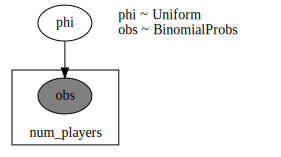

In [13]:
numpyro.render_model(fully_pooled, model_args=(at_bats,hits), render_distributions=True)

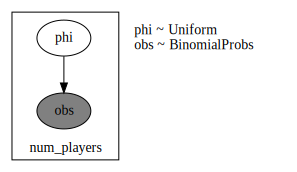

In [14]:
numpyro.render_model(not_pooled, model_args=(at_bats,hits), render_distributions=True)

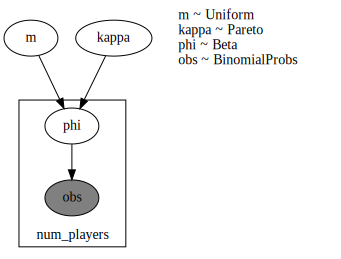

In [15]:
numpyro.render_model(partially_pooled, model_args=(at_bats,hits), render_distributions=True)

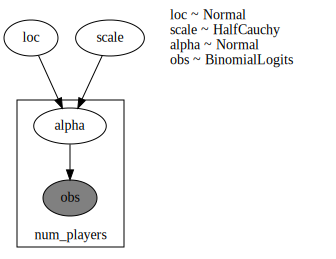

In [16]:
numpyro.render_model(partially_pooled_with_logit, model_args=(at_bats,hits), render_distributions=True)

In [17]:
algo = "NUTS"
num_warmup = 1500
num_samples = 3000
num_chains = 1
disable_progbar = False
device = "cpu"

In [18]:
numpyro.set_platform(device)
numpyro.set_host_device_count(num_chains)

In [19]:
for i, model in enumerate((fully_pooled, not_pooled, partially_pooled, partially_pooled_with_logit)):
    rng_key, rng_key_predict = random.split(random.PRNGKey(i + 1))
    zs = run_inference(model, at_bats, hits, rng_key)
    predict(model, at_bats, hits, zs, rng_key_predict, player_names)
    predict(model,season_at_bats,season_hits,zs,rng_key_predict,player_names,train=False,)

sample: 100%|██████████| 4500/4500 [00:04<00:00, 1123.28it/s, 3 steps of size 1.10e+00. acc. prob=0.90]



 ==============================fully_pooled - TRAIN============================== 

                        At-bats ActualHits  Pred(p25)  Pred(p50)  Pred(p75)
    Roberto Clemente         45         18      10.00      12.00      14.00 

      Frank Robinson         45         17      10.00      12.00      14.00 

        Frank Howard         45         16      10.00      12.00      14.00 

       Jay Johnstone         45         15      10.00      12.00      14.00 

           Ken Berry         45         14      10.00      12.00      14.00 

         Jim Spencer         45         14      10.00      12.00      14.00 

       Don Kessinger         45         13      10.00      12.00      14.00 

       Luis Alvarado         45         12      10.00      12.00      14.00 

           Ron Santo         45         11      10.00      12.00      14.00 

         Ron Swaboda         45         11      10.00      12.00      14.00 

     Rico Petrocelli         45         10      10.00      

sample: 100%|██████████| 4500/4500 [00:04<00:00, 1027.50it/s, 7 steps of size 5.75e-01. acc. prob=0.89]



 ==============================not_pooled - TRAIN============================== 

                        At-bats ActualHits  Pred(p25)  Pred(p50)  Pred(p75)
    Roberto Clemente         45         18      15.00      18.00      21.00 

      Frank Robinson         45         17      14.00      17.00      20.00 

        Frank Howard         45         16      13.00      16.00      19.00 

       Jay Johnstone         45         15      12.00      15.00      18.00 

           Ken Berry         45         14      11.00      14.00      17.00 

         Jim Spencer         45         14      11.00      14.00      17.00 

       Don Kessinger         45         13      10.00      13.00      16.00 

       Luis Alvarado         45         12      10.00      12.00      15.00 

           Ron Santo         45         11       9.00      11.00      14.00 

         Ron Swaboda         45         11       9.00      11.00      14.00 

     Rico Petrocelli         45         10       8.00      10

sample: 100%|██████████| 4500/4500 [00:06<00:00, 714.97it/s, 7 steps of size 4.34e-01. acc. prob=0.78] 



 ==============================partially_pooled - TRAIN============================== 

                        At-bats ActualHits  Pred(p25)  Pred(p50)  Pred(p75)
    Roberto Clemente         45         18      12.00      14.00      17.00 

      Frank Robinson         45         17      11.00      14.00      17.00 

        Frank Howard         45         16      11.00      14.00      16.00 

       Jay Johnstone         45         15      11.00      13.00      16.00 

           Ken Berry         45         14      10.00      13.00      15.00 

         Jim Spencer         45         14      11.00      13.00      15.00 

       Don Kessinger         45         13      10.00      12.00      15.00 

       Luis Alvarado         45         12      10.00      12.00      14.00 

           Ron Santo         45         11       9.00      12.00      14.00 

         Ron Swaboda         45         11       9.00      12.00      14.00 

     Rico Petrocelli         45         10       9.00  

sample: 100%|██████████| 4500/4500 [00:05<00:00, 857.49it/s, 31 steps of size 2.08e-01. acc. prob=0.85] 



 ==============================partially_pooled_with_logit - TRAIN============================== 

                        At-bats ActualHits  Pred(p25)  Pred(p50)  Pred(p75)
    Roberto Clemente         45         18      11.00      13.00      16.00 

      Frank Robinson         45         17      11.00      13.00      15.00 

        Frank Howard         45         16      10.00      13.00      15.00 

       Jay Johnstone         45         15      10.00      12.00      15.00 

           Ken Berry         45         14      10.00      12.00      15.00 

         Jim Spencer         45         14      10.00      12.00      15.00 

       Don Kessinger         45         13      10.00      12.00      14.00 

       Luis Alvarado         45         12      10.00      12.00      14.00 

           Ron Santo         45         11       9.00      11.00      14.00 

         Ron Swaboda         45         11       9.00      12.00      14.00 

     Rico Petrocelli         45         10  